In [1]:
import glob
import logging
import os
import time
import urllib.parse
from datetime import datetime, date

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pytz
import tensorflow as tf
from astral import LocationInfo
from astral.sun import sun
from keras import layers, models
from prophet import Prophet
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

import strat_defs # custom functions
import prep_data

In [2]:
def gen_powerset(some_list):
    powerset = [[]]

    for i in some_list:
        powerset += [x + [i] for x in powerset]

    return powerset

In [3]:
sp_df_files = glob.glob('sp_df_*.csv')
sp_df_latest = max(sp_df_files, key=os.path.getctime)
sp_df_raw = pd.read_csv(sp_df_latest, parse_dates=['Date added'])

stocks_df, wiki_pageviews, ffr_raw, weather, gt_adjusted = prep_data.load_data()

In [4]:
set(sp_df_raw['GICS Sector'])

{'Communication Services',
 'Consumer Discretionary',
 'Consumer Staples',
 'Energy',
 'Financials',
 'Health Care',
 'Industrials',
 'Information Technology',
 'Materials',
 'Real Estate',
 'Utilities',
 nan}

In [5]:
# sp_df_raw

### Set configuration and parameters for model testing

In [7]:
# Indicator Configuration
moving_average_config = prep_data.MovingAverageConfig(short_window=10, long_window=50)
bollinger_config = prep_data.BollingerConfig(window=90, num_std=3.0)
macd_config = prep_data.MACDConfig(short_window=12, long_window=26)

# Backtest Configuration
keras_config = strat_defs.KerasConfig(proba=0.5, sequence_length=30, epochs=20)
proba_config = strat_defs.ProbaConfig(knn = 0.5, logit = 0.5, mlp = 0.5, rf = 0.5, svc = 0.5, xgboost = 0.5)

backtest_config = strat_defs.BacktestConfig(
    logit_warm_start = False, # true with drop tickers = false fails. not sure why.
    proba = proba_config,
    keras = keras_config
)

**s_date**\
data start date S&P 500 minimum is 1993-01-29, Wikipedia page views minimum is 2015-07-01

**exclude_vars**\
enum {"Open","High","Low","Close","Adj Close","Volume","movement", "views"}

**strategy_list**\
enum {"Hold","KNN","Logit","MLP","RandomForest","SVC_proba","XGBoost","Keras","Perfection"}

From fast to slow (usually): Hold, Perfection, KNN, Logit, XGBoost, SVC_proba(200s), MLP (2978s), Keras(4048s)

For Best Prediction, I'm removing strategies that do not give a probability

\
*If testing Breakout, "High" and "Low" cannot be excluded*

In [9]:
s_date = "2015-07-01"
exclude_vars = ("Open","High","Low","Close","Adj Close","Volume")

# initial_train_period = 1890 # 2015-07-01 start predicting in 2023
initial_train_period = 2140 # 2015-07-01 start predicting in 2024
# initial_train_period = 7535 # 1993-01-29 start predicting in 2024
random_state = 42
n_jobs = -1

# Stocks to test
these_dont_work = ['GOOG', 'FOX', 'NWS']
to_test = list(sp_df_raw.loc[sp_df_raw['Date added']<="2015-07-01",'Symbol'])
to_test = [x for x in to_test if x not in these_dont_work]
                                           
# Strategies to test
strategy_list = ["Hold","KNN","Logit"] # 2h 2min with n_jobs = -1, KNN always best prob for some reason?
# strategy_list = ["Hold","KNN","Logit", "XGBoost"] # 13h 47min with n_jobs = None, KNN always best prob for some reason?
#                                                   # 12h 23min with n_jobs = -1

### Run models

In [11]:
%%time
strat_bds, strat_mods = {}, {}
for ticker in to_test:
    print(f'\n\033[1m{ticker}\033[0m')
    indicator_config = prep_data.IndicatorConfig(ticker=ticker)
    prepd_data = prep_data.prep_data(stocks_df, wiki_pageviews, ffr_raw, weather, gt_adjusted, config=indicator_config, drop_tickers=True)

    df_for_chart = prepd_data.loc[prepd_data['Date']>=s_date].reset_index(drop=True)
    df_for_chart = df_for_chart.drop(columns=[
        col for col in df_for_chart.columns 
        if any(col.startswith(prefix) for prefix in exclude_vars) and col != indicator_config.target+"_"+ticker
    ])
    df_for_chart = df_for_chart.dropna(axis='columns') # drop columns with an na

    print(f'Training on data set with {len(df_for_chart)} rows and {df_for_chart.shape[1]-1} features')

    # Calculate portfolio value over time
    for strat in strategy_list:
        start_time = time.time()
        print(f'{strat}', end=" ")
        backtested_data,model,score = strat_defs.backtest_strategy(
            data=df_for_chart,
            strategy=strat,
            target='Adj Close',
            ticker=ticker,
            config=backtest_config,
            initial_train_period=initial_train_period,
            random_state=random_state,
            n_jobs=n_jobs
        )
        end_time = time.time()
        print(f'score = {score}, time = {end_time-start_time}')

        strat_bds[f'{ticker}_{strat}'] = backtested_data
        strat_mods[f'{ticker}_{strat}'] = model


MMM
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.08211398124694824
KNN score = 0.6911525974025974, time = 11.63940691947937
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5332792207792207, time = 7.324324131011963

ABT
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0024881362915039062
KNN score = 0.6801948051948052, time = 10.398612022399902
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5385551948051948, time = 13.191734075546265

ABBV
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0026078224182128906
KNN score = 0.7098214285714286, time = 10.502252101898193
Logit score = 0.5430194805194806, time = 13.859364986419678

ACN
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0031120777130126953
KNN score = 0.682224025974026, time = 10.221346139907837
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


score = 0.5487012987012987, time = 13.98082709312439

ADBE
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.004224061965942383
KNN score = 0.6806006493506493, time = 11.88334321975708
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


score = 0.5369318181818182, time = 15.485072135925293

AES
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0024192333221435547
KNN score = 0.6935876623376623, time = 10.004631996154785
Logit score = 0.5267857142857143, time = 13.843879222869873

AFL
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002549886703491211
KNN score = 0.6814123376623377, time = 11.80315899848938
Logit score = 0.5616883116883117, time = 13.562400102615356

A
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002716064453125
KNN score = 0.6854707792207793, time = 10.019624948501587
Logit score = 0.5393668831168831, time = 7.1640870571136475

APD
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0026187896728515625
KNN score = 0.6875, time = 10.070056915283203
Logit score = 0.5446428571428571, time = 16.20463991165161

AKAM
Training on data set with 2465 rows and 31 features
Hold score = None

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5280032467532467, time = 13.316115140914917

ALL
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002695798873901367
KNN score = 0.6858766233766234, time = 6.203429937362671
Logit score = 0.5426136363636364, time = 13.811373949050903

GOOGL
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.002666950225830078
KNN score = 0.6907467532467533, time = 9.89015507698059
Logit score = 0.5369318181818182, time = 13.161578178405762

MO
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002583742141723633
KNN score = 0.6919642857142857, time = 9.873064041137695
Logit score = 0.5487012987012987, time = 13.18605899810791

AMZN
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.003362894058227539
KNN score = 0.7025162337662337, time = 13.563135147094727
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


score = 0.536525974025974, time = 13.330873727798462

AEE
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002557039260864258
KNN score = 0.6976461038961039, time = 9.447405099868774
Logit score = 0.5450487012987013, time = 13.630693912506104

AEP
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0026869773864746094
KNN score = 0.7025162337662337, time = 9.78992509841919
Logit score = 0.549512987012987, time = 13.364880800247192

AXP
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0027267932891845703
KNN score = 0.6810064935064936, time = 9.712122201919556
Logit score = 0.5243506493506493, time = 14.231024265289307

AIG
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025141239166259766
KNN score = 0.679788961038961, time = 9.724196910858154
Logit score = 0.5284090909090909, time = 13.016538858413696

AMT
Training on data set with 2465 rows and 30 features
Hold s

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


score = 0.5308441558441559, time = 13.47615098953247

AMP
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025637149810791016
KNN score = 0.6814123376623377, time = 10.321105241775513
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5275974025974026, time = 13.335460186004639

AME
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0028400421142578125
KNN score = 0.6676136363636364, time = 9.921008825302124
Logit score = 0.5373376623376623, time = 17.10831093788147

AMGN
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002832174301147461
KNN score = 0.674512987012987, time = 10.841216802597046
Logit score = 0.5458603896103896, time = 7.057950258255005

APH
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025780200958251953
KNN score = 0.676948051948052, time = 9.889981985092163
Logit score = 0.5458603896103896, time = 13.12166690826416

ADI
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025119781494140625
KNN score = 0.6992694805194806, time = 11.649055004119873
Logit score = 0.5458603896103896, time = 13.038621187210083

AON
Training on data set with 2465 rows and 31 features
Hold

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5340909090909091, time = 13.167158842086792

AIZ
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002828836441040039
KNN score = 0.7053571428571429, time = 9.665747880935669
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


score = 0.5434253246753247, time = 13.106130838394165

T
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025429725646972656
KNN score = 0.679788961038961, time = 9.505740880966187
Logit score = 0.5381493506493507, time = 13.097531080245972

ADSK
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0026259422302246094
KNN score = 0.6948051948051948, time = 5.242829084396362
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5361201298701299, time = 13.273097038269043

ADP
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0030050277709960938
KNN score = 0.695211038961039, time = 11.186232089996338
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5568181818181818, time = 13.208636283874512

AZO
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0024089813232421875
KNN score = 0.692775974025974, time = 9.673402070999146
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5267857142857143, time = 12.895961046218872

AVB
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025501251220703125
KNN score = 0.689935064935065, time = 9.751073122024536
Logit score = 0.5308441558441559, time = 13.071905851364136

AVY
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0033271312713623047
KNN score = 0.6854707792207793, time = 9.538838148117065
Logit score = 0.5227272727272727, time = 12.96776795387268

BALL
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002485036849975586
KNN score = 0.6806006493506493, time = 9.907341957092285
Logit score = 0.523538961038961, time = 13.269951343536377

BAC
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.12618517875671387
KNN score = 0.6895292207792207, time = 11.354353904724121
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5174512987012987, time = 13.022135734558105

BAX
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025968551635742188
KNN score = 0.6891233766233766, time = 9.345032930374146
Logit score = 0.5300324675324676, time = 13.442638158798218

BDX
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0028159618377685547
KNN score = 0.689935064935065, time = 9.477475881576538
Logit score = 0.544237012987013, time = 13.234915733337402

BRK-B
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025751590728759766
KNN score = 0.6968344155844156, time = 9.564461708068848
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5381493506493507, time = 13.140508890151978

BBY
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025420188903808594
KNN score = 0.702922077922078, time = 10.534574031829834
Logit score = 0.5328733766233766, time = 15.127675294876099

BIIB
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002683877944946289
KNN score = 0.6883116883116883, time = 10.413244724273682
Logit score = 0.5353084415584416, time = 7.339864253997803

BLK
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002541065216064453
KNN score = 0.6773538961038961, time = 9.632758140563965
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


score = 0.5239448051948052, time = 7.350687026977539

BK
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002630949020385742
KNN score = 0.6935876623376623, time = 10.359328031539917
Logit score = 0.5353084415584416, time = 14.131590843200684

BA
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025169849395751953
KNN score = 0.6818181818181818, time = 9.993314981460571
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5426136363636364, time = 7.768572092056274

BKNG
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.002608776092529297
KNN score = 0.6862824675324676, time = 9.807487964630127
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


score = 0.5349025974025974, time = 14.711834907531738

BSX
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002482175827026367
KNN score = 0.6923701298701299, time = 10.615204095840454
Logit score = 0.5527597402597403, time = 14.854051113128662

BMY
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002518177032470703
KNN score = 0.6923701298701299, time = 9.968891143798828
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


score = 0.5332792207792207, time = 7.7863218784332275

AVGO
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0024449825286865234
KNN score = 0.6919642857142857, time = 10.304046154022217
Logit score = 0.53125, time = 14.414115190505981

BF-B
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.002485990524291992
KNN score = 0.6907467532467533, time = 10.380197286605835
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5223214285714286, time = 14.091251134872437

BXP
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.0026950836181640625
KNN score = 0.7138798701298701, time = 9.918839931488037
Logit score = 0.5085227272727273, time = 14.877990245819092

CHRW
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.002473115921020508
KNN score = 0.6757305194805194, time = 11.316168785095215
Logit score = 0.5458603896103896, time = 14.544528245925903

CPB
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.0025517940521240234
KNN score = 0.6753246753246753, time = 9.968349933624268
Logit score = 0.538961038961039, time = 14.069937944412231

COF
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0024940967559814453
KNN score = 0.6875, time = 10.484456062316895
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5166396103896104, time = 7.368746995925903

CAH
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025179386138916016
KNN score = 0.6988636363636364, time = 10.193707942962646
Logit score = 0.5332792207792207, time = 13.600914239883423

KMX
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002608776092529297
KNN score = 0.6846590909090909, time = 9.63346004486084
Logit score = 0.5267857142857143, time = 14.641462087631226

CCL
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025348663330078125
KNN score = 0.6875, time = 11.43516206741333
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5186688311688312, time = 7.121304035186768

CAT
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0024750232696533203
KNN score = 0.6838474025974026, time = 9.897589206695557
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


score = 0.5263798701298701, time = 13.878066062927246

CBRE
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025959014892578125
KNN score = 0.6704545454545454, time = 10.404952049255371
Logit score = 0.533685064935065, time = 13.97291088104248

COR
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.002443075180053711
KNN score = 0.6891233766233766, time = 10.129609107971191
Logit score = 0.5401785714285714, time = 7.198986053466797

CNP
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002496004104614258
KNN score = 0.6883116883116883, time = 10.160911083221436
Logit score = 0.5478896103896104, time = 14.430744886398315

CF
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002644062042236328
KNN score = 0.6700487012987013, time = 10.237988948822021
Logit score = 0.515422077922078, time = 7.2764880657196045

SCHW
Training on data set with 2465 rows and 31 features
Hol

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


score = 0.5373376623376623, time = 7.3716981410980225

CMG
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025300979614257812
KNN score = 0.6814123376623377, time = 10.445161819458008
Logit score = 0.5482954545454546, time = 13.990994930267334

CB
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.0025949478149414062
KNN score = 0.676948051948052, time = 9.893511056900024
Logit score = 0.5328733766233766, time = 14.417609930038452

CI
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025238990783691406
KNN score = 0.6919642857142857, time = 10.391509056091309
Logit score = 0.5381493506493507, time = 15.008493185043335

CINF
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0026040077209472656
KNN score = 0.6793831168831169, time = 10.161265134811401
Logit score = 0.5353084415584416, time = 14.188249826431274

CTAS
Training on data set with 2465 rows and 31 features

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5369318181818182, time = 14.076068878173828

C
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025110244750976562
KNN score = 0.6858766233766234, time = 9.792847871780396
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5060876623376623, time = 7.26793098449707

CLX
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002541065216064453
KNN score = 0.6830357142857143, time = 9.773046016693115
Logit score = 0.5482954545454546, time = 15.534229040145874

CME
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025069713592529297
KNN score = 0.6830357142857143, time = 10.16260313987732
Logit score = 0.5369318181818182, time = 13.976260900497437

CMS
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002532958984375
KNN score = 0.6810064935064936, time = 9.732797861099243
Logit score = 0.5531655844155844, time = 15.465508222579956

KO
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0024862289428710938
KNN score = 0.7045454545454546, time = 10.044573068618774
Logit score = 0.5438311688311688, time = 7.255588054656982

CTSH
Training on data set with 2465 rows and 31 features
Hold sco

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.538961038961039, time = 7.3004679679870605

CL
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0024199485778808594
KNN score = 0.6858766233766234, time = 9.917145729064941
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5304383116883117, time = 14.015918016433716

CMCSA
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002717256546020508
KNN score = 0.6842532467532467, time = 11.718770265579224
Logit score = 0.5239448051948052, time = 14.845446109771729

CAG
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.0024480819702148438
KNN score = 0.6826298701298701, time = 9.84782099723816
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5478896103896104, time = 14.311327934265137

COP
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002485036849975586
KNN score = 0.689935064935065, time = 10.456247091293335
Logit score = 0.507711038961039, time = 6.973668098449707

ED
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0024518966674804688
KNN score = 0.692775974025974, time = 9.998213052749634
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5458603896103896, time = 14.286542892456055

STZ
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0027892589569091797
KNN score = 0.6895292207792207, time = 9.952648878097534
Logit score = 0.5211038961038961, time = 14.67712688446045

GLW
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002537965774536133
KNN score = 0.6810064935064936, time = 11.628899097442627
Logit score = 0.5263798701298701, time = 7.1672351360321045

COST
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025069713592529297
KNN score = 0.6964285714285714, time = 10.055987119674683
Logit score = 0.5511363636363636, time = 13.965571165084839

CTRA
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.0025320053100585938
KNN score = 0.6891233766233766, time = 10.152400970458984
Logit score = 0.5454545454545454, time = 7.6394617557525635

CCI
Training on data set with 2465 rows and 31 feature

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


score = 0.5381493506493507, time = 8.141361951828003

CVS
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002476930618286133
KNN score = 0.6976461038961039, time = 9.959765911102295
Logit score = 0.5190746753246753, time = 13.868583917617798

DHR
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002670764923095703
KNN score = 0.6968344155844156, time = 10.087047100067139
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5324675324675324, time = 13.981066942214966

DRI
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0024230480194091797
KNN score = 0.6732954545454546, time = 10.342172145843506
Logit score = 0.5300324675324676, time = 7.278966903686523

DVA
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0026319026947021484
KNN score = 0.6992694805194806, time = 9.953565120697021
Logit score = 0.5320616883116883, time = 13.787147998809814

DE
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002505064010620117
KNN score = 0.7025162337662337, time = 9.95766806602478
Logit score = 0.546672077922078, time = 14.359196901321411

DAL
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002712726593017578
KNN score = 0.6858766233766234, time = 10.880926847457886
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5462662337662337, time = 13.900557041168213

DVN
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0026929378509521484
KNN score = 0.669237012987013, time = 10.234195947647095
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5202922077922078, time = 13.471681118011475

DFS
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002557992935180664
KNN score = 0.6968344155844156, time = 23.833878993988037
Logit score = 0.5271915584415584, time = 24.238942861557007

DG
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025229454040527344
KNN score = 0.7008928571428571, time = 21.527795791625977
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5166396103896104, time = 23.5887508392334

DLTR
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0028023719787597656
KNN score = 0.6866883116883117, time = 21.961536169052124
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


score = 0.525974025974026, time = 15.177402973175049

DOV
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002610921859741211
KNN score = 0.6858766233766234, time = 21.39038634300232
Logit score = 0.5422077922077922, time = 23.382511854171753

DHI
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002564668655395508
KNN score = 0.6879058441558441, time = 25.277605295181274
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5284090909090909, time = 24.157783031463623

DTE
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0024847984313964844
KNN score = 0.6818181818181818, time = 24.447208881378174
Logit score = 0.5515422077922078, time = 24.188445806503296

DUK
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0024640560150146484
KNN score = 0.6858766233766234, time = 23.018651962280273
Logit score = 0.5422077922077922, time = 25.256083011627197

EMN
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002599954605102539
KNN score = 0.6858766233766234, time = 22.604880809783936
Logit score = 0.5174512987012987, time = 24.09298586845398

ETN
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0026040077209472656
KNN score = 0.6976461038961039, time = 22.89473295211792
Logit score = 0.5328733766233766, time = 24.1176598072052

EBAY
Training on data set with 2465 rows and 30 features
H

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5357142857142857, time = 26.25819993019104

ECL
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002518177032470703
KNN score = 0.6956168831168831, time = 21.462788105010986
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


score = 0.5324675324675324, time = 23.98334312438965

EIX
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002523183822631836
KNN score = 0.7146915584415584, time = 22.060352087020874
Logit score = 0.5247564935064936, time = 25.82245111465454

EW
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002685070037841797
KNN score = 0.6956168831168831, time = 21.872069120407104
Logit score = 0.5231331168831169, time = 24.003807067871094

EA
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0026111602783203125
KNN score = 0.6996753246753247, time = 22.369293928146362
Logit score = 0.523538961038961, time = 25.676471948623657

ELV
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.0025620460510253906
KNN score = 0.6777597402597403, time = 23.046145915985107
Logit score = 0.520698051948052, time = 14.721443176269531

EMR
Training on data set with 2465 rows and 31 features
Hold 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.523538961038961, time = 24.377164840698242

ETR
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025179386138916016
KNN score = 0.6842532467532467, time = 22.12712287902832
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5353084415584416, time = 25.076380729675293

EOG
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0027701854705810547
KNN score = 0.6708603896103896, time = 23.850929021835327
Logit score = 0.5271915584415584, time = 15.75629210472107

EFX
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0026459693908691406
KNN score = 0.6996753246753247, time = 23.65825891494751
Logit 

/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


score = 0.5438311688311688, time = 26.551594972610474

EQIX
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0028150081634521484
KNN score = 0.6935876623376623, time = 23.494670152664185
Logit score = 0.5373376623376623, time = 24.943216800689697

EQR
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0027670860290527344
KNN score = 0.6984577922077922, time = 62.730453968048096
Logit score = 0.5596590909090909, time = 15.031908988952637

ESS
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.002593994140625
KNN score = 0.6911525974025974, time = 21.644435167312622
Logit score = 0.538961038961039, time = 22.641568899154663

EL
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.00255584716796875
KNN score = 0.6777597402597403, time = 21.251307010650635
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


score = 0.5219155844155844, time = 23.444298028945923

ES
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002669095993041992
KNN score = 0.6842532467532467, time = 22.366171836853027
Logit score = 0.5353084415584416, time = 24.35733699798584

EXC
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002777099609375
KNN score = 0.7000811688311688, time = 24.278961896896362
Logit score = 0.5487012987012987, time = 23.724045038223267

EXPE
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.002515077590942383
KNN score = 0.6891233766233766, time = 20.5328209400177
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


score = 0.5251623376623377, time = 14.317909002304077

EXPD
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002671957015991211
KNN score = 0.6887175324675324, time = 22.529974222183228
Logit score = 0.5320616883116883, time = 24.544608116149902

XOM
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0029129981994628906
KNN score = 0.6838474025974026, time = 24.144641160964966
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.518262987012987, time = 29.370621919631958

FFIV
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.002763986587524414
KNN score = 0.705762987012987, time = 21.548655033111572
Logit score = 0.5308441558441559, time = 22.738481760025024

FAST
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.0025882720947265625
KNN score = 0.6923701298701299, time = 22.811853170394897
Logit score = 0.5349025974025974, time = 23.870434045791626

FDX
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0026099681854248047
KNN score = 0.6801948051948052, time = 22.96531391143799
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


score = 0.5263798701298701, time = 25.211466789245605

FIS
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002515077590942383
KNN score = 0.6866883116883117, time = 22.876105070114136
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5340909090909091, time = 25.825303077697754

FITB
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.0025877952575683594
KNN score = 0.6875, time = 20.78190517425537
Logit score = 0.5284090909090909, time = 23.85692286491394

FE
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025739669799804688
KNN score = 0.6842532467532467, time = 23.10883092880249
Logit score = 0.5482954545454546, time = 25.6469247341156

FI
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0026531219482421875
KNN score = 0.7118506493506493, time = 24.78882622718811
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


score = 0.5482954545454546, time = 25.73264789581299

F
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0028150081634521484
KNN score = 0.682224025974026, time = 22.728678941726685
Logit score = 0.5405844155844156, time = 32.65313100814819

BEN
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0024950504302978516
KNN score = 0.692775974025974, time = 23.152814865112305
Logit score = 0.5211038961038961, time = 25.360280990600586

FCX
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002783060073852539
KNN score = 0.6956168831168831, time = 24.688260793685913
Logit score = 0.544237012987013, time = 18.498344898223877

GRMN
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002553224563598633
KNN score = 0.685064935064935, time = 9.782225847244263
Logit score = 0.5357142857142857, time = 13.800822019577026

GE
Training on data set with 2465 rows and 31 features
Hold sco

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5409902597402597, time = 7.633375883102417

GEN
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.002566814422607422
KNN score = 0.6814123376623377, time = 11.25225305557251
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


score = 0.5251623376623377, time = 13.737034797668457

GD
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0026712417602539062
KNN score = 0.6956168831168831, time = 9.70072078704834
Logit score = 0.5397727272727273, time = 13.832982063293457

GIS
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002585887908935547
KNN score = 0.6806006493506493, time = 9.748551845550537
Logit score = 0.5300324675324676, time = 13.884320974349976

GM
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0026030540466308594
KNN score = 0.6842532467532467, time = 9.943778991699219
Logit score = 0.5263798701298701, time = 13.859687805175781

GPC
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002569913864135742
KNN score = 0.666801948051948, time = 9.70852279663086
Logit score = 0.533685064935065, time = 14.034539222717285

GILD
Training on data set with 2465 rows and 31 features
Hold sco

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5296266233766234, time = 14.472748756408691

GL
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.002562999725341797
KNN score = 0.6943993506493507, time = 9.882251977920532
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5584415584415584, time = 13.696014881134033

GS
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025539398193359375
KNN score = 0.6814123376623377, time = 9.620501041412354
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5255681818181818, time = 7.40349817276001

HAL
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025250911712646484
KNN score = 0.6866883116883117, time = 9.541077852249146
Logit score = 0.5093344155844156, time = 13.726777076721191

HIG
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002602100372314453
KNN score = 0.6996753246753247, time = 9.441403150558472
Logit score = 0.5409902597402597, time = 13.860800981521606

HAS
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0026972293853759766
KNN score = 0.682224025974026, time = 11.693214893341064
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


score = 0.5223214285714286, time = 13.759253978729248

HCA
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.0026869773864746094
KNN score = 0.6939935064935064, time = 10.551146984100342
Logit score = 0.5296266233766234, time = 8.357234954833984

DOC
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.002595186233520508
KNN score = 0.685064935064935, time = 10.347723960876465
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


score = 0.5284090909090909, time = 13.647382020950317

HSIC
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002649068832397461
KNN score = 0.6988636363636364, time = 4.805105924606323
Logit score = 0.536525974025974, time = 14.394870042800903

HSY
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002504110336303711
KNN score = 0.6773538961038961, time = 9.719584941864014
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


score = 0.5292207792207793, time = 14.422697067260742

HES
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002584695816040039
KNN score = 0.6765422077922078, time = 11.472529172897339
Logit score = 0.5487012987012987, time = 7.7221760749816895

HD
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025000572204589844
KNN score = 0.6875, time = 9.655825138092041
Logit score = 0.5357142857142857, time = 14.380139112472534

HON
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0026798248291015625
KNN score = 0.6956168831168831, time = 9.486771821975708
Logit score = 0.5369318181818182, time = 13.735203742980957

HRL
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025849342346191406
KNN score = 0.6635551948051948, time = 9.958482027053833
Logit score = 0.533685064935065, time = 13.868919849395752

HST
Training on data set with 2465 rows and 31 features
Hold score = No

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


score = 0.5190746753246753, time = 14.441103219985962

ICE
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025360584259033203
KNN score = 0.6968344155844156, time = 9.672433853149414
Logit score = 0.533685064935065, time = 14.036380052566528

IFF
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002516031265258789
KNN score = 0.6915584415584416, time = 9.423628091812134
Logit score = 0.5142045454545454, time = 13.788877725601196

IP
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002591848373413086
KNN score = 0.6895292207792207, time = 9.419901132583618
Logit score = 0.5215097402597403, time = 13.837934017181396

IPG
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.0025131702423095703
KNN score = 0.698051948051948, time = 9.84081482887268
Logit score = 0.5320616883116883, time = 13.517283916473389

INTU
Training on data set with 2465 rows and 31 features
Hold s

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5373376623376623, time = 14.1666898727417

IRM
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002460956573486328
KNN score = 0.6814123376623377, time = 17.080815315246582
Logit score = 0.5474837662337663, time = 13.69913387298584

JBHT
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002811908721923828
KNN score = 0.6935876623376623, time = 9.392417907714844
Logit score = 0.5474837662337663, time = 15.528544187545776

J
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.0024929046630859375
KNN score = 0.6749188311688312, time = 10.976907014846802
Logit score = 0.5296266233766234, time = 6.968579053878784

JNJ
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002599000930786133
KNN score = 0.6931818181818182, time = 9.542105913162231
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


score = 0.5215097402597403, time = 13.858942031860352

JCI
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025780200958251953
KNN score = 0.6854707792207793, time = 9.380480766296387
Logit score = 0.533685064935065, time = 13.842376947402954

JPM
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0026547908782958984
KNN score = 0.6960227272727273, time = 9.627597093582153
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5219155844155844, time = 13.996675252914429

JNPR
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0027480125427246094
KNN score = 0.7008928571428571, time = 9.392581939697266
Logit score = 0.5284090909090909, time = 13.968508005142212

K
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.0026259422302246094
KNN score = 0.702922077922078, time = 9.540017127990723
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5324675324675324, time = 13.799527883529663

KEY
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002421140670776367
KNN score = 0.6789772727272727, time = 9.69895076751709
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5340909090909091, time = 13.791563034057617

KMB
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0027437210083007812
KNN score = 0.6911525974025974, time = 9.605711936950684
Logit score = 0.536525974025974, time = 13.610142230987549

KIM
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002629995346069336
KNN score = 0.6887175324675324, time = 9.413027048110962
Logit score = 0.5357142857142857, time = 14.421827793121338

KMI
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0026650428771972656
KNN score = 0.6773538961038961, time = 9.322954893112183
Logit score = 0.515422077922078, time = 14.4287269115448

KLAC
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.0025949478149414062
KNN score = 0.705762987012987, time = 10.525340795516968
Logit score = 0.546672077922078, time = 7.037640810012817

KR
Training on data set with 2465 rows and 31 features
Hold sco

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


score = 0.5284090909090909, time = 13.970645189285278

LRCX
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002466917037963867
KNN score = 0.6830357142857143, time = 9.538160800933838
Logit score = 0.5503246753246753, time = 13.663788080215454

LEN
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0026650428771972656
KNN score = 0.6834415584415584, time = 9.525923013687134
Logit score = 0.5263798701298701, time = 16.590080976486206

LLY
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025551319122314453
KNN score = 0.689935064935065, time = 9.613390922546387
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


score = 0.5361201298701299, time = 13.670679807662964

LIN
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.002668142318725586
KNN score = 0.6854707792207793, time = 9.313224077224731
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5377435064935064, time = 14.209692239761353

LMT
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025298595428466797
KNN score = 0.6895292207792207, time = 9.503128051757812
Logit score = 0.5405844155844156, time = 13.883305072784424

L
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025281906127929688
KNN score = 0.6789772727272727, time = 9.52077579498291
Logit score = 0.5665584415584416, time = 13.566339254379272

LOW
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002705097198486328
KNN score = 0.6988636363636364, time = 9.57513976097107
Logit score = 0.541801948051948, time = 15.220111846923828

LYB
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0024318695068359375
KNN score = 0.6939935064935064, time = 9.645959854125977
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5137987012987013, time = 7.243300914764404

MTB
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0026750564575195312
KNN score = 0.6883116883116883, time = 10.06853199005127
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5381493506493507, time = 7.31136417388916

MPC
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002451181411743164
KNN score = 0.6883116883116883, time = 9.421028137207031
Logit score = 0.5344967532467533, time = 13.737839937210083

MAR
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025420188903808594
KNN score = 0.6866883116883117, time = 9.620786905288696
Logit score = 0.5332792207792207, time = 13.920387029647827

MMC
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.002569913864135742
KNN score = 0.6870941558441559, time = 9.280839920043945
Logit score = 0.560064935064935, time = 13.646615028381348

MLM
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025746822357177734
KNN score = 0.6923701298701299, time = 11.469025135040283
Logit score = 0.5174512987012987, time = 13.692827939987183

MAS
Training on data set with 2465 rows and 31 features
Hold 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


score = 0.5499188311688312, time = 13.849660873413086

MKC
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002518177032470703
KNN score = 0.6931818181818182, time = 9.780639886856079
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5397727272727273, time = 14.047415018081665

MCD
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0024917125701904297
KNN score = 0.698051948051948, time = 9.51285696029663
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


score = 0.5377435064935064, time = 13.785863876342773

MCK
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0027489662170410156
KNN score = 0.6964285714285714, time = 11.128863096237183
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5507305194805194, time = 13.674457788467407

MDT
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025091171264648438
KNN score = 0.6789772727272727, time = 9.533493041992188
Logit score = 0.5316558441558441, time = 13.658142805099487

MRK
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0024538040161132812
KNN score = 0.6915584415584416, time = 9.504964113235474
Logit score = 0.5202922077922078, time = 14.16371774673462

META
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.002530813217163086
KNN score = 0.6968344155844156, time = 9.447436094284058
Logit score = 0.5349025974025974, time = 7.629645109176636

MET
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025322437286376953
KNN score = 0.6773538961038961, time = 9.395212650299072
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


score = 0.5320616883116883, time = 13.595162153244019

MCHP
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025382041931152344
KNN score = 0.6919642857142857, time = 11.143346071243286
Logit score = 0.5308441558441559, time = 7.315593004226685

MU
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002534151077270508
KNN score = 0.6801948051948052, time = 9.426162004470825
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5255681818181818, time = 13.724383354187012

MSFT
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025758743286132812
KNN score = 0.6907467532467533, time = 9.613945245742798
Logit score = 0.544237012987013, time = 13.702063798904419

MHK
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002669095993041992
KNN score = 0.6741071428571429, time = 9.507395029067993
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5073051948051948, time = 14.208123922348022

TAP
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.002665996551513672
KNN score = 0.6838474025974026, time = 9.425087928771973
Logit score = 0.5332792207792207, time = 13.651616096496582

MDLZ
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0024449825286865234
KNN score = 0.6939935064935064, time = 9.581419944763184
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5247564935064936, time = 13.983267068862915

MNST
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025300979614257812
KNN score = 0.6838474025974026, time = 9.45220398902893
Logit score = 0.5405844155844156, time = 7.502025842666626

MCO
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025899410247802734
KNN score = 0.692775974025974, time = 9.500163793563843
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5527597402597403, time = 13.655102968215942

MS
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0029981136322021484
KNN score = 0.6862824675324676, time = 9.437856197357178
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5194805194805194, time = 13.660242795944214

MOS
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025899410247802734
KNN score = 0.689935064935065, time = 9.384850263595581
Logit score = 0.5186688311688312, time = 13.838406801223755

MSI
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025098323822021484
KNN score = 0.6773538961038961, time = 9.52640676498413
Logit score = 0.5491071428571429, time = 15.213733911514282

NDAQ
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.002763032913208008
KNN score = 0.6915584415584416, time = 9.531332731246948
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5381493506493507, time = 13.610246896743774

NTAP
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002565145492553711
KNN score = 0.6826298701298701, time = 9.656616926193237
Logit score = 0.5324675324675324, time = 13.689432144165039

NFLX
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0026149749755859375
KNN score = 0.6988636363636364, time = 9.427680969238281
Logit score = 0.5227272727272727, time = 13.887276887893677

NEM
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.002546072006225586
KNN score = 0.6915584415584416, time = 9.423604011535645
Logit score = 0.5296266233766234, time = 14.138805866241455

NWSA
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.0026617050170898438
KNN score = 0.6858766233766234, time = 9.39745569229126
Logit score = 0.5296266233766234, time = 13.771821975708008

NEE
Training on data set with 2465 rows and 31 features
H

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5280032467532467, time = 13.691504716873169

NTRS
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002647876739501953
KNN score = 0.6757305194805194, time = 5.124486923217773
Logit score = 0.5215097402597403, time = 14.941931009292603

NOC
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002505064010620117
KNN score = 0.6895292207792207, time = 9.554666996002197
Logit score = 0.536525974025974, time = 13.722517967224121

NRG
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0024890899658203125
KNN score = 0.682224025974026, time = 9.560025215148926
Logit score = 0.5450487012987013, time = 13.714701890945435

NUE
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002535104751586914
KNN score = 0.6830357142857143, time = 9.431883096694946
Logit score = 0.5211038961038961, time = 7.2480549812316895

NVDA
Training on data set with 2465 rows and 31 features
Hold

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


score = 0.5474837662337663, time = 13.733228921890259

ORLY
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025358200073242188
KNN score = 0.685064935064935, time = 9.68008804321289
Logit score = 0.5434253246753247, time = 13.633263111114502

OXY
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025861263275146484
KNN score = 0.6907467532467533, time = 11.276444911956787
Logit score = 0.5109577922077922, time = 13.679666757583618

OMC
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002515077590942383
KNN score = 0.6810064935064936, time = 9.701462030410767
Logit score = 0.5397727272727273, time = 14.302715063095093

OKE
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.002576112747192383
KNN score = 0.6826298701298701, time = 9.410888910293579
Logit score = 0.5413961038961039, time = 13.602854251861572

ORCL
Training on data set with 2465 rows and 31 features
Ho

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5146103896103896, time = 13.648526668548584

PH
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002444028854370117
KNN score = 0.695211038961039, time = 9.481801986694336
Logit score = 0.5239448051948052, time = 13.845084190368652

PAYX
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025298595428466797
KNN score = 0.6785714285714286, time = 9.400304079055786
Logit score = 0.5422077922077922, time = 13.705556154251099

PNR
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0028150081634521484
KNN score = 0.6785714285714286, time = 9.567996263504028
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


score = 0.528814935064935, time = 13.742075204849243

PEP
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0028960704803466797
KNN score = 0.6903409090909091, time = 15.21858286857605
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


score = 0.5357142857142857, time = 13.623697996139526

PFE
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002550840377807617
KNN score = 0.6826298701298701, time = 10.736447095870972
Logit score = 0.5401785714285714, time = 7.276579856872559

PM
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002569913864135742
KNN score = 0.6935876623376623, time = 9.33030390739441
Logit score = 0.5377435064935064, time = 14.251624822616577

PSX
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0023889541625976562
KNN score = 0.698051948051948, time = 9.465002059936523
Logit score = 0.5296266233766234, time = 13.89052700996399

PNW
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.0027039051055908203
KNN score = 0.6826298701298701, time = 9.691089868545532
Logit score = 0.5377435064935064, time = 13.579433917999268

PNC
Training on data set with 2465 rows and 31 features
Hold sc

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5223214285714286, time = 13.792432308197021

PPG
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.003319978713989258
KNN score = 0.6785714285714286, time = 11.348282814025879
Logit score = 0.5251623376623377, time = 13.632412195205688

PPL
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0028870105743408203
KNN score = 0.689935064935065, time = 9.521470785140991
Logit score = 0.5458603896103896, time = 13.652684926986694

PFG
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002835988998413086
KNN score = 0.689935064935065, time = 9.44950819015503
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5243506493506493, time = 13.71839427947998

PG
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002513885498046875
KNN score = 0.6801948051948052, time = 9.496947288513184
Logit score = 0.5381493506493507, time = 13.69194507598877

PGR
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0024597644805908203
KNN score = 0.6911525974025974, time = 9.531102180480957
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5434253246753247, time = 13.715357065200806

PLD
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002562999725341797
KNN score = 0.6943993506493507, time = 11.189411878585815
Logit score = 0.5426136363636364, time = 13.6178719997406

PRU
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0026209354400634766
KNN score = 0.6818181818181818, time = 9.350147724151611
Logit score = 0.5243506493506493, time = 14.150636911392212

PEG
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002482175827026367
KNN score = 0.6838474025974026, time = 9.800725936889648
Logit score = 0.5462662337662337, time = 13.71579909324646

PSA
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002698183059692383
KNN score = 0.692775974025974, time = 9.325518131256104
Logit score = 0.5373376623376623, time = 13.715643167495728

PHM
Training on data set with 2465 rows and 31 features
Hold sc

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5223214285714286, time = 13.600765943527222

DGX
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0024139881134033203
KNN score = 0.6826298701298701, time = 9.516430854797363
Logit score = 0.5304383116883117, time = 13.670305967330933

RL
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002526998519897461
KNN score = 0.6712662337662337, time = 9.383848905563354
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


score = 0.5393668831168831, time = 7.3721818923950195

RTX
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.0025441646575927734
KNN score = 0.7008928571428571, time = 9.537182092666626
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5219155844155844, time = 7.148673057556152

O
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.0025560855865478516
KNN score = 0.6887175324675324, time = 9.402199745178223
Logit score = 0.5430194805194806, time = 15.194839000701904

REGN
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002553701400756836
KNN score = 0.7069805194805194, time = 9.404049158096313
Logit score = 0.528814935064935, time = 7.183932065963745

RF
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002666950225830078
KNN score = 0.6846590909090909, time = 6.457669019699097
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5255681818181818, time = 13.639657020568848

RSG
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025522708892822266
KNN score = 0.6935876623376623, time = 9.45803713798523
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.557224025974026, time = 13.805038213729858

RVTY
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.002604961395263672
KNN score = 0.692775974025974, time = 9.422741889953613
Logit score = 0.5263798701298701, time = 13.748148918151855

ROK
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025510787963867188
KNN score = 0.6834415584415584, time = 9.45734190940857
Logit score = 0.525974025974026, time = 7.241682291030884

ROP
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.002808094024658203
KNN score = 0.6773538961038961, time = 9.656023025512695
Logit score = 0.546672077922078, time = 13.753242015838623

ROST
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002657175064086914
KNN score = 0.6956168831168831, time = 4.210441827774048
Logit score = 0.5194805194805194, time = 8.029668092727661

RCL
Training on data set with 2465 rows and 30 features
Hold scor

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5142045454545454, time = 13.780732870101929

SPGI
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.002476215362548828
KNN score = 0.6732954545454546, time = 9.599433183670044
Logit score = 0.5474837662337663, time = 13.64829421043396

CRM
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002526998519897461
KNN score = 0.6806006493506493, time = 9.373764753341675
Logit score = 0.5324675324675324, time = 13.61353588104248

SLB
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002454042434692383
KNN score = 0.6887175324675324, time = 9.568189144134521
Logit score = 0.5194805194805194, time = 16.02001118659973

STX
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025250911712646484
KNN score = 0.6895292207792207, time = 9.667280912399292
Logit score = 0.5361201298701299, time = 13.766211986541748

SHW
Training on data set with 2465 rows and 31 features
Hold s

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


score = 0.525974025974026, time = 13.682415962219238

SPG
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025670528411865234
KNN score = 0.679788961038961, time = 9.63160490989685
Logit score = 0.5357142857142857, time = 7.180356979370117

SWKS
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0023839473724365234
KNN score = 0.6887175324675324, time = 9.86712908744812
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5251623376623377, time = 14.148508310317993

SJM
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002593994140625
KNN score = 0.7025162337662337, time = 9.267700910568237
Logit score = 0.5405844155844156, time = 14.073287010192871

SNA
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0029091835021972656
KNN score = 0.6704545454545454, time = 11.167464017868042
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5349025974025974, time = 13.493953943252563

SO
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002772092819213867
KNN score = 0.6943993506493507, time = 9.319159984588623
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5446428571428571, time = 13.517930030822754

LUV
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025467872619628906
KNN score = 0.6895292207792207, time = 9.839619874954224
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5308441558441559, time = 7.1471333503723145

SWK
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025947093963623047
KNN score = 0.6862824675324676, time = 9.332533121109009
Logit score = 0.5142045454545454, time = 14.088585138320923

SBUX
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002557039260864258
KNN score = 0.6761363636363636, time = 9.653313159942627
Logit score = 0.5247564935064936, time = 7.120387077331543

STT
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002446889877319336
KNN score = 0.6830357142857143, time = 9.781805992126465
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.523538961038961, time = 13.894864320755005

SYK
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0024650096893310547
KNN score = 0.6976461038961039, time = 9.536766052246094
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.533685064935065, time = 13.850297212600708

SYY
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.00251007080078125
KNN score = 0.676948051948052, time = 9.837867975234985
Logit score = 0.5280032467532467, time = 13.580196857452393

TPR
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.0026140213012695312
KNN score = 0.6891233766233766, time = 9.564828157424927
Logit score = 0.525974025974026, time = 7.084821939468384

TGT
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025980472564697266
KNN score = 0.6895292207792207, time = 9.526676177978516
Logit score = 0.5174512987012987, time = 13.620816230773926

TEL
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025768280029296875
KNN score = 0.7000811688311688, time = 9.543065786361694
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5271915584415584, time = 14.940967321395874

TXN
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0024902820587158203
KNN score = 0.700487012987013, time = 9.355591058731079
Logit score = 0.5698051948051948, time = 7.167863607406616

TXT
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0024881362915039062
KNN score = 0.6939935064935064, time = 8.393940925598145
Logit score = 0.5405844155844156, time = 7.117754697799683

TMO
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002499103546142578
KNN score = 0.679788961038961, time = 10.022892951965332
Logit score = 0.5300324675324676, time = 6.997228145599365

TJX
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025250911712646484
KNN score = 0.6956168831168831, time = 9.600366115570068
Logit score = 0.5284090909090909, time = 7.5402350425720215

TSCO
Training on data set with 2465 rows and 30 features
Hold 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5263798701298701, time = 13.526543855667114

TT
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.0025451183319091797
KNN score = 0.6956168831168831, time = 9.581287860870361
Logit score = 0.538961038961039, time = 15.180966854095459

TRV
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0024721622467041016
KNN score = 0.6814123376623377, time = 9.381464958190918
Logit score = 0.5482954545454546, time = 14.125831842422485

TFC
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.0024938583374023438
KNN score = 0.6830357142857143, time = 9.477705955505371
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5263798701298701, time = 14.188186883926392

TSN
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025839805603027344
KNN score = 0.6939935064935064, time = 9.591813802719116
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


score = 0.5357142857142857, time = 13.786728382110596

USB
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0026502609252929688
KNN score = 0.6866883116883117, time = 9.57657527923584
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5397727272727273, time = 13.784327983856201

UNP
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002518892288208008
KNN score = 0.6984577922077922, time = 9.403920888900757
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


score = 0.525974025974026, time = 9.08499789237976

UPS
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0026051998138427734
KNN score = 0.7017045454545454, time = 9.564910888671875
Logit score = 0.5202922077922078, time = 13.985918998718262

URI
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.00234222412109375
KNN score = 0.685064935064935, time = 9.290075063705444
Logit score = 0.5251623376623377, time = 13.572955131530762

UNH
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002547025680541992
KNN score = 0.6862824675324676, time = 9.702803134918213
Logit score = 0.5397727272727273, time = 13.40223503112793

UHS
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0026988983154296875
KNN score = 0.6887175324675324, time = 9.458489894866943
Logit score = 0.518262987012987, time = 13.808837175369263

VLO
Training on data set with 2465 rows and 31 features
Hold score

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5344967532467533, time = 15.866508722305298

VTR
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.002708911895751953
KNN score = 0.6984577922077922, time = 9.408647775650024
Logit score = 0.5426136363636364, time = 13.627873659133911

VRSN
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0024902820587158203
KNN score = 0.695211038961039, time = 6.320900917053223
Logit score = 0.5430194805194806, time = 13.652624130249023

VZ
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025501251220703125
KNN score = 0.674512987012987, time = 10.467388153076172
Logit score = 0.5328733766233766, time = 13.853133916854858

VRTX
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0024390220642089844
KNN score = 0.6883116883116883, time = 9.480859279632568
Logit score = 0.5357142857142857, time = 7.213302135467529

VTRS
Training on data set with 2465 rows and 30 features
Ho

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5608766233766234, time = 13.739152193069458

VMC
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0026788711547851562
KNN score = 0.6862824675324676, time = 9.37830400466919
Logit score = 0.515827922077922, time = 7.155080318450928

GWW
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0024869441986083984
KNN score = 0.6948051948051948, time = 9.587414979934692
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5296266233766234, time = 13.747666120529175

WBA
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002518177032470703
KNN score = 0.6923701298701299, time = 9.426765203475952
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5434253246753247, time = 7.248341083526611

WMT
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025000572204589844
KNN score = 0.7025162337662337, time = 9.433078050613403
Logit score = 0.5377435064935064, time = 13.432427167892456

DIS
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002714872360229492
KNN score = 0.6801948051948052, time = 9.577721118927002
Logit score = 0.5219155844155844, time = 9.108849048614502

WM
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.002540111541748047
KNN score = 0.7000811688311688, time = 9.507216215133667
Logit score = 0.5637175324675324, time = 13.520861864089966

WAT
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002607107162475586
KNN score = 0.7025162337662337, time = 9.499928712844849
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5263798701298701, time = 13.887089967727661

WEC
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.002444028854370117
KNN score = 0.6943993506493507, time = 9.773318767547607
Logit score = 0.5426136363636364, time = 13.625562906265259

WFC
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0024929046630859375
KNN score = 0.6972402597402597, time = 9.539238214492798
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

score = 0.5340909090909091, time = 7.559473037719727

WELL
Training on data set with 2465 rows and 30 features
Hold score = None, time = 0.0024881362915039062
KNN score = 0.6883116883116883, time = 9.628412961959839
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


score = 0.5462662337662337, time = 13.619640827178955

WDC
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002638101577758789
KNN score = 0.6846590909090909, time = 10.961621046066284
Logit score = 0.5142045454545454, time = 13.555020093917847

WY
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002480030059814453
KNN score = 0.6728896103896104, time = 9.471302032470703
Logit score = 0.5251623376623377, time = 13.471923112869263

WMB
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025010108947753906
KNN score = 0.6866883116883117, time = 9.613486051559448
Logit 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


score = 0.525974025974026, time = 13.470542192459106

WYNN
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0024518966674804688
KNN score = 0.6818181818181818, time = 9.319287061691284
Logit score = 0.5133928571428571, time = 7.130104064941406

XEL
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.002527952194213867
KNN score = 0.6956168831168831, time = 9.308195114135742
Logit score = 0.5491071428571429, time = 14.064342021942139

XYL
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0024721622467041016
KNN score = 0.6911525974025974, time = 11.346157789230347
Logit score = 0.5178571428571429, time = 7.289166212081909

YUM
Training on data set with 2465 rows and 31 features
Hold score = None, time = 0.0025250911712646484
KNN score = 0.6838474025974026, time = 9.91487431526184
Logit score = 0.5349025974025974, time = 13.363003015518188

ZBH
Training on data set with 2465 rows and 31 features
Hold

In [33]:
proba_strats = [x for x in strategy_list if x not in ["Hold"]]

combos = gen_powerset(proba_strats)
combos.remove([])

all_mod_results_dic = {}
for mods in combos:
    print(mods)
    df_to_build = strat_bds[to_test[0]+"_"+mods[0]][['Date']] # start with just date column

    # Get results for all tickers in to_test, in this subgroup of models, eg ['KNN_Logit']
    for ticker in to_test:
    
        # Get the results for a ticker with the first model in mods list
        df_prev = strat_bds[ticker+"_"+mods[0]][['Date','Daily_Return','proba_1']]
        # df_prev['proba_1'] = 1 - df_prev['proba_1'] # why does this make Logit so much better?!?!?!?
                                                      # maybe a beter question is why is KNN so good?
        df_prev = df_prev.rename(columns={'Daily_Return': f'Daily_Return_{ticker}'
                                          ,'proba_1': f'{ticker}_proba_1{mods[0]}'})
        df_to_build = df_to_build.merge(df_prev,on='Date')

        # Get results for this ticker for other models in mods
        for model in mods[1:]:  ########################### only for ['KNN', 'Logit'] which just goes to KNN! (testing 3/31)
            df = strat_bds[ticker+"_"+model][['Date','proba_1']].copy()
            # df['proba_1'] = 1 - df['proba_1']
            df = df.rename(columns={'proba_1': f'{ticker}_proba_1{model}'})
            df_to_build = df_to_build.merge(df,on='Date')

    proba_cols = [col for col in df_to_build.columns if 'proba_1' in col]

    df_to_build['proba_1max'] = df_to_build[proba_cols].max(axis=1) # max value acoss all proba_1 cols

    # Column name that proba_1max is in
    mask = df_to_build[proba_cols].notna().any(axis=1)
    df_to_build.loc[mask, 'proba_1max_col'] = df_to_build.loc[mask, proba_cols].idxmax(axis=1, skipna=True)
    
    # Daily return column name of relevant ticker
    df_to_build['proba_1max_ticker'] = "Daily_Return_"+df_to_build['proba_1max_col'].str.split('_').str[0]

    # Value of daily return column of relevant ticker
    df_to_build['proba_1max_ticker_Daily_return'] = df_to_build.apply(
        lambda row: row[row['proba_1max_ticker']] if pd.notnull(row['proba_1max_col']) else row['Daily_Return_SPY'], axis=1
    )

    df_to_build['Strategy_Return'] = df_to_build['proba_1max_ticker_Daily_return']

    df_to_build.loc[df_to_build['proba_1max'] < 0.7, 'Strategy_Return'] = df_to_build['Daily_Return_SPY']
    df_to_build.loc[0, 'Strategy_Return'] = np.nan

    # df_to_build has results for this model for all tickers
    all_mod_results_dic["_".join(mods)] = df_to_build

['KNN']
['Logit']
['KNN', 'Logit']


### Results

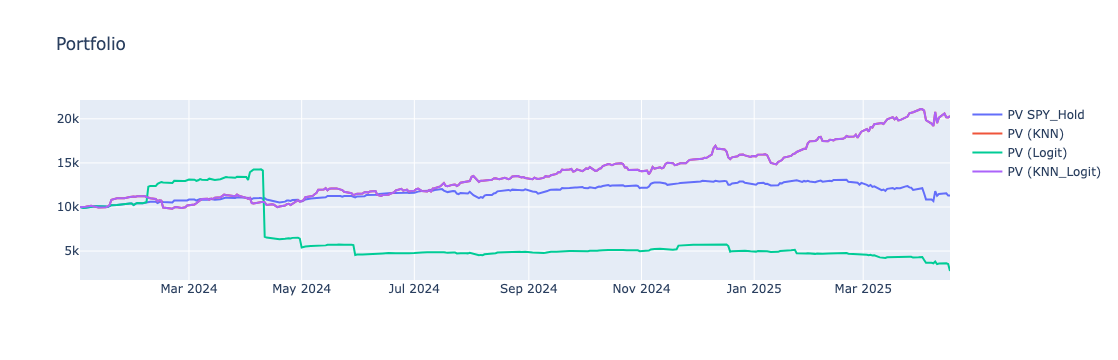

In [34]:
initial_capital = 10000 # scalar

# Plot Daily Portfolio Value
fig = go.Figure()

df = strat_bds['SPY_Hold'][initial_train_period:].copy()
df.loc[initial_train_period, 'Strategy_Return'] = 0
df['Portfolio_Value'] = (1 + df['Strategy_Return']).cumprod() * initial_capital

fig.add_trace(go.Scatter(x=df['Date'], y=df['Portfolio_Value'],
                                 mode='lines', name='PV SPY_Hold'))

end_val = {'SPY':df['Portfolio_Value'].values[-1]}
for mods in combos:
    df = all_mod_results_dic["_".join(mods)][initial_train_period:].copy()
    df.loc[initial_train_period, 'Strategy_Return'] = 0
    df['Portfolio_Value'] = (1 + df['Strategy_Return']).cumprod() * initial_capital

    fig.add_trace(go.Scatter(x=df['Date'], y=df['Portfolio_Value'],
                             mode='lines', name=f"PV ({'_'.join(mods)})"))
    end_val['_'.join(mods)] = df['Portfolio_Value'].values[-1]

fig.update_layout(title="Portfolio")
fig.show()

In [15]:
pl_df = pd.DataFrame([end_val]).transpose().reset_index()
pl_df = pl_df.rename(columns={0:'end_val','index':'ticker'})
pl_df['vs_SPY'] = pl_df['end_val'] - end_val['SPY']
pl_df.sort_values(by='vs_SPY',ascending=False)

,ticker,end_val,vs_SPY
1,KNN,20330.596383,9016.384446
3,KNN_Logit,20330.596383,9016.384446
0,SPY,11314.211937,0.000000
2,Logit,2739.334335,-8574.877601


In [16]:
for i in combos:
    j ='_'.join(i)
    pl = end_val[j]-end_val['SPY']

    if pl < 0:
        print(f'{j} P&L: -${pl*-1:,.2f}')
    else:
        print(f'{j} P&L: ${pl:,.2f}')

KNN P&L: $9,016.38
Logit P&L: -$8,574.88
KNN_Logit P&L: $9,016.38
